# Modelo con datos aumentados

# Carga de datos

In [2]:
import pandas as pd
import numpy as np

# ===========================
# 1 Cargar y preparar datos
# ===========================
df = pd.read_csv("../data/aptos_bogota_enriched.csv")

# Renombrar columnas calculadas
df = df.drop("estrato", axis=1).rename(columns={
    "estrato_calculado": "estrato",
    "barrio_calculado": "barrio",
    "upz_calculada": "upz"
})


umbral_precio = 1_500_000_000  # 1500 millones
df = df[df["precio_venta"] <= umbral_precio].copy()

# Eliminar filas sin barrio (necesario para imputar)
df = df[~df['barrio'].isnull()].reset_index(drop=True)

print(f"Registros después de limpieza: {len(df)}")

# ===========================
# 2 Imputación jerárquica
# ===========================
def imputar_por_barrio(df, columna, metodo='media'):
    if metodo == 'media':
        imputacion = df.groupby('barrio')[columna].transform('mean')
    elif metodo == 'moda':
        imputacion = df.groupby('barrio')[columna].transform(
            lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]
        )
    df[columna] = df[columna].fillna(imputacion)
    return df

# Variables a imputar
for col, metodo in [
    ('administracion', 'media'),
    ('estado', 'moda'),
    ('upz', 'moda'),
    ('catastral', 'media'),
    ('comercial', 'media'),
    ('antiguedad', 'moda')
]:
    if col in df.columns:
        df = imputar_por_barrio(df, col, metodo)

print("Imputación por barrio completada.")

# ===========================
# 3 Transformación logarítmica
# ===========================
df['precio_venta_log'] = np.log1p(df['precio_venta'])
df['area_log'] = np.log1p(df['area'])

# Confirmación de variables
print("\nColumnas transformadas añadidas:")
print(['precio_venta_log', 'area_log'])

df.head()


Registros después de limpieza: 21996
Imputación por barrio completada.

Columnas transformadas añadidas:
['precio_venta_log', 'area_log']


,precio_venta,area,habitaciones,banos,administracion,parqueaderos,sector,antiguedad,latitud,longitud,...,parks_and_recreation_2000,infrastructure_services_2000,cultural_amenities_2000,catastral,comercial,upz,barrio,localidad_calculada,precio_venta_log,area_log
0,339000000.0,76.0,3.0,2.0,300000.0,1.0,BRITALIA,ENTRE 10 Y 20 ANOS,4.746592,-74.057571,...,35,165,7,3.227303e+06,3.848904e+06,USAQUEN,SANTA ANA OCCIDENTAL,USAQUEN,19.641511,4.343805
1,440898168.0,54.0,3.0,2.0,305000.0,0.0,LA SABANA,ENTRE 0 Y 5 ANOS,4.607378,-74.082648,...,89,86,1,1.718168e+06,2.144399e+06,EL PRADO,EL PLAN,SUBA,19.904324,4.007333
2,158000000.0,43.0,2.0,2.0,106600.0,0.0,TIBABUYES,ENTRE 10 Y 20 ANOS,4.740109,-74.113675,...,144,85,1,1.627592e+06,2.322134e+06,EL PRADO,MAZUREN,SUBA,18.878106,3.784190
3,222800000.0,48.0,3.0,2.0,151000.0,0.0,VERBENAL,MAS DE 20 ANOS,4.763900,-74.025280,...,40,178,6,3.550046e+06,4.278709e+06,SANTA BARBARA,MOLINOS NORTE,USAQUEN,19.221785,3.891820
4,128900000.0,47.0,2.0,1.0,86500.0,0.0,TINTAL SUR,ENTRE 10 Y 20 ANOS,4.632698,-74.198111,...,39,190,20,3.340397e+06,4.172320e+06,EL REFUGIO,LOS ROSALES,CHAPINERO,18.674547,3.871201


In [3]:
import pandas as pd
import os

def save_cv_results_to_csv(cv_results, output_path):
    """
    Guarda los resultados fold-by-fold de cross_validate en un CSV.
    Crea los directorios padre si no existen.
    Convierte métricas negativas (MAE, MSE, RMSE) a valores positivos.
    """

    # Crear directorios padre
    parent = os.path.dirname(output_path)
    if parent:
        os.makedirs(parent, exist_ok=True)

    # Convertir dict a DataFrame
    df = pd.DataFrame(cv_results)

    # Renombrar columnas test_*
    df.columns = [col.replace("test_", "") for col in df.columns]

    # Convertir métricas negativas a positivas
    for col in df.columns:
        name = col.lower()
        if "mae" in name or "mse" in name or "rmse" in name:
            df[col] = df[col].abs()

    # Guardar CSV limpio
    df.to_csv(output_path, index=False)
    print(f"Archivo guardado en: {output_path}")


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# ===========================
# 4 Definir target y features
# ===========================
target = "precio_venta_log"

# Columnas que no se usarán como predictores
ignore_cols = [
    "precio_venta", "precio_venta_log", "sector",
    "localidad_calculada", "area_log"
]

# Variables predictoras
features = [col for col in df.columns if col not in ignore_cols]

X = df[features].copy()
y = df[target].copy()

# ===========================
# 5 Clasificar variables
# ===========================
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "bool"]).columns.tolist()

print(f"Variables numéricas: {len(numeric_features)}")
print(f"Variables categóricas: {len(categorical_features)}")

# ===========================
# 6 Preprocesamiento
# ===========================
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

print("Preprocesamiento configurado correctamente")


Variables numéricas: 55
Variables categóricas: 4
Preprocesamiento configurado correctamente


In [5]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np

# ===========================
# 7 Definir modelos
# ===========================
modelos = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(alpha=0.1, max_iter=10000),
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(
        n_estimators=200, max_depth=None, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1),
    "LightGBM": LGBMRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=-1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1),
     # "SVR": SVR(kernel="rbf", C=10, epsilon=0.3)
}

# ===========================
# 8 Configurar validación cruzada
# ===========================
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scoring = {
    "RMSE": make_scorer(root_mean_squared_error, greater_is_better=False),
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "R2": make_scorer(r2_score)
}

In [ ]:
resultados = []

# ===========================
# 9 Evaluar cada modelo
# ===========================
for nombre, modelo in modelos.items():
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", modelo)])
    print("Evaluando modelo: ", nombre)
    cv_result = cross_validate(
        pipeline, X, y, cv=kf, scoring=scoring, n_jobs=-1, return_train_score=False
    )
    resultados.append({
        "Modelo": nombre,
        "RMSE medio": -np.mean(cv_result["test_RMSE"]),
        "RMSE std": np.std(cv_result["test_RMSE"]),
        "MAE medio": -np.mean(cv_result["test_MAE"]),
        "R² medio": np.mean(cv_result["test_R2"]),
        "RMSE values": -cv_result["test_RMSE"]
    })

# ===========================
# 10 Mostrar resultados ordenados
# ===========================
resultados_df = pd.DataFrame(resultados).sort_values(by="RMSE medio")
print(resultados_df.round(3))


Evaluando modelo:  LinearRegression
Evaluando modelo:  Lasso
Evaluando modelo:  Ridge
Evaluando modelo:  RandomForest
Evaluando modelo:  XGBoost
Evaluando modelo:  LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5724
[LightGBM] [Info] Total Bins 5724
[LightGBM] [Info] Number of data points in the train set: 19797, number of used features: 306
[LightGBM] [Info] Number of data points in the train set: 19796, number of used features: 311
[LightGBM] [Info] Start training from score 20.113012
[LightGBM] [Info] Start training from score 20.112596
[LightGBM] 

/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/roman

             Modelo  RMSE medio  RMSE std  MAE medio  R² medio  \
5          LightGBM       0.148     0.004      0.111     0.943   
4           XGBoost       0.148     0.004      0.112     0.942   
3      RandomForest       0.156     0.005      0.115     0.936   
2             Ridge       0.253     0.008      0.193     0.832   
0  LinearRegression       0.255     0.008      0.194     0.830   
1             Lasso       0.310     0.006      0.244     0.748   

                                         RMSE values  
5  [0.14904742402886215, 0.1479970852182651, 0.14...  
4  [0.14979800871253912, 0.14855566903203285, 0.1...  
3  [0.15720748690203704, 0.16059991434343743, 0.1...  
2  [0.2572752198882208, 0.2488077484363322, 0.257...  
0  [0.25936475512065116, 0.24967698231401034, 0.2...  
1  [0.31428641106714517, 0.3063893175357295, 0.30...  


/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


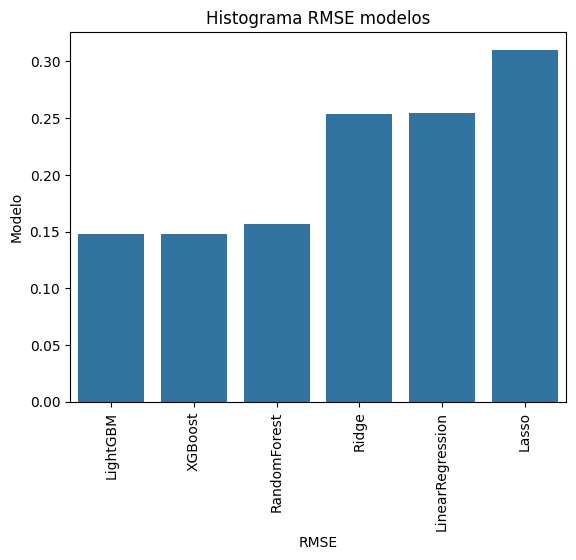

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(y=resultados_df['RMSE medio'], x=resultados_df["Modelo"])
plt.title("Histograma RMSE modelos")
plt.xlabel('RMSE')
plt.xticks(rotation=90)
plt.ylabel('Modelo')
plt.show()


In [9]:
xgboost_pipeline = None
for index, row in resultados_df.iterrows():
    if row["Modelo"] == "XGBoost":
        print(row["Modelo"])
        print(row)
        print(row["RMSE values"])

XGBoost
Modelo                                                   XGBoost
RMSE medio                                              0.148261
RMSE std                                                0.003874
MAE medio                                               0.111823
R² medio                                                0.942335
RMSE values    [0.14979800871253912, 0.14855566903203285, 0.1...
Name: 4, dtype: object
[0.14979801 0.14855567 0.14980296 0.15554334 0.15078023 0.14807777
 0.14856063 0.14069007 0.14294123 0.14785822]


Los resultados de la validación cruzada evidencian diferencias claras en el desempeño de los distintos algoritmos evaluados sobre el conjunto de datos enriquecido. Los modelos basados en árboles de decisión con técnicas de ensamble (XGBoost, LightGBM y Random Forest) superaron ampliamente a los modelos lineales y de soporte vectorial.

Tanto XGBoost como LightGBM obtuvieron un RMSE promedio de 0.17 (en escala logarítmica), equivalente a un error relativo aproximado del 18 % sobre el precio real, y un coeficiente de determinación R² de 0.956, lo que indica una capacidad explicativa muy alta. En comparación, los modelos lineales (Ridge, Lasso y Regresión Lineal) alcanzaron R² entre 0.88 y 0.88, mientras que el SVR presentó un rendimiento intermedio (R² ≈ 0.91).

Estos resultados confirman que los modelos no lineales y con capacidad de capturar interacciones complejas entre las variables —en especial las derivadas del enriquecimiento geoespacial— son más adecuados para el problema de estimación de precios inmobiliarios. En adelante, XGBoost se selecciona como modelo base enriquecido para la optimización e interpretación detallada.

## Búsqueda de mejores hiperparámetros

In [6]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import time

# ===========================
# 1️⃣ Definir espacio de búsqueda
# ===========================

# Espacio para XGBoost
xgb_param_dist = {
    # Complejidad controlada
    "model__n_estimators": randint(200, 500),        # antes hasta 800
    "model__max_depth": randint(3, 7),               # antes hasta 10

    # Learning rate moderado
    "model__learning_rate": uniform(0.02, 0.06),     # rango estrecho y razonable

    # Submuestreo para reducir varianza
    "model__subsample": uniform(0.7, 0.2),           # [0.7, 0.9]
    "model__colsample_bytree": uniform(0.7, 0.2),    # [0.7, 0.9]

    # Regularización explícita
    "model__min_child_weight": randint(1, 6),
    "model__gamma": uniform(0.0, 2.0),
    "model__reg_lambda": uniform(0.5, 2.0),
    "model__reg_alpha": uniform(0.0, 0.5),
}

# ===========================
# 2️⃣ Búsqueda aleatoria
# ===========================


pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", XGBRegressor(random_state=42))])

search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=xgb_param_dist,
    n_iter=25,
    scoring="neg_root_mean_squared_error",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

print(f"\nBuscando mejores parámetros para xgboost...")
inicio = time.time()
search.fit(X, y)
duracion = time.time() - inicio

print(f"Mejor RMSE (XGBoost): {-search.best_score_:.4f}")
print(f"Mejores parámetros: {search.best_params_}")
print(f"Duración: {duracion/60:.1f} minutos")

best_results = {
    "best_rmse": -search.best_score_,
    "best_params": search.best_params_,
    "search_time_min": round(duracion / 60, 2)
}

# ===========================
# 3️⃣ Mostrar resumen
# ===========================
results_df = pd.DataFrame(best_results).T
print("\nResultados de optimización:")
print(results_df)



Buscando mejores parámetros para xgboost...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END model__colsample_bytree=0.7749080237694724, model__gamma=1.9014286128198323, model__learning_rate=0.0639196365086843, model__max_depth=3, model__min_child_weight=5, model__n_estimators=302, model__reg_alpha=0.22291637642679557, model__reg_lambda=0.6999498316360058, model__subsample=0.7918497783931734; total time=   4.1s
[CV] END model__colsample_bytree=0.7749080237694724, model__gamma=1.9014286128198323, model__learning_rate=0.0639196365086843, model__max_depth=3, model__min_child_weight=5, model__n_estimators=302, model__reg_alpha=0.22291637642679557, model__reg_lambda=0.6999498316360058, model__subsample=0.7918497783931734; total time=   4.2s
[CV] END model__colsample_bytree=0.7749080237694724, model__gamma=1.9014286128198323, model__learning_rate=0.0639196365086843, model__max_depth=3, model__min_child_weight=5, model__n_estimators=302, model__reg_alpha=0.2229163764267

## Modelo con mejores parámetros

/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [11:42:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "model__colsample_bytree", "model__gamma", "model__learning_rate", "model__max_depth", "model__min_child_weight", "model__n_estimators", "model__reg_alpha", "model__reg_lambda", "model__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


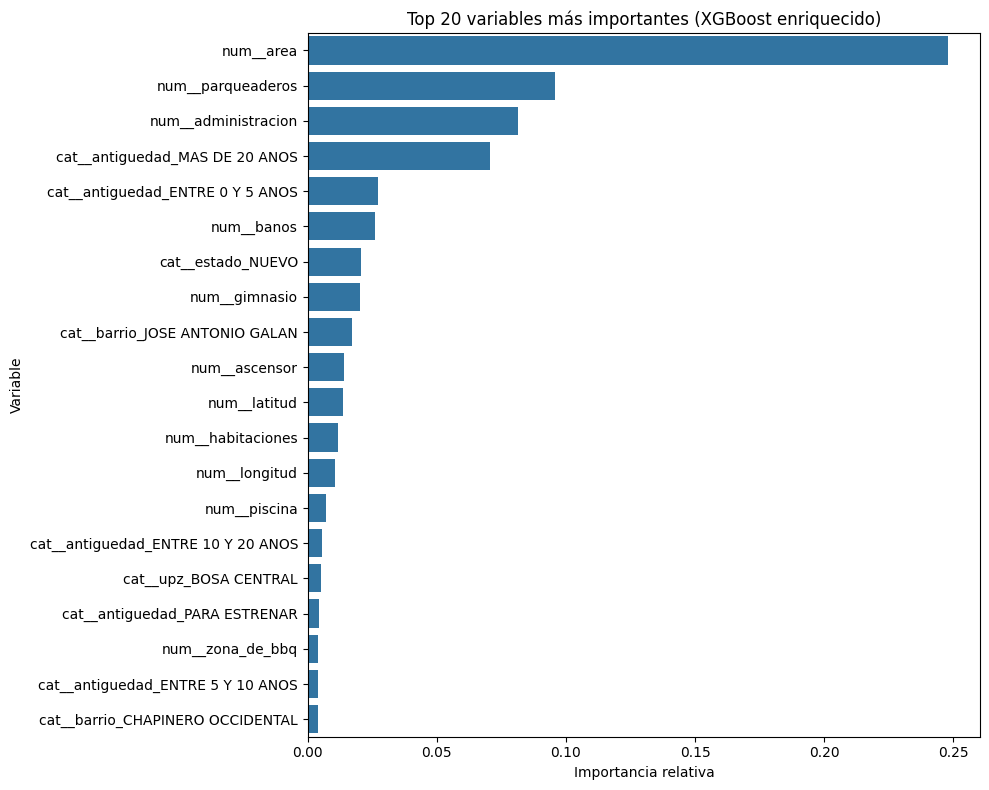

Importancia de variables exportada a feature_importance_xgb.csv


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

# Mejor RMSE (LightGBM): 0.1733
# Mejores parámetros: {'model__bagging_freq': 2, 'model__colsample_bytree': np.float64(0.9136811769773325), 'model__lambda_l1': np.float64(0.1480869299533999), 'model__lambda_l2': np.float64(0.9977404850489419), 'model__learning_rate': np.float64(0.036006860856517095), 'model__max_depth': 0, 'model__min_data_in_leaf': 21, 'model__n_estimators': 419, 'model__num_leaves': 73, 'model__subsample': np.float64(0.7099152198701645)}

# Mejor RMSE (XGBoost): 0.1737
# Mejores parámetros: {'model__colsample_bytree': np.float64(0.7586976349436075), 'model__gamma': np.float64(0.02815964543016891), 'model__learning_rate': np.float64(0.03193054424532831), 'model__max_depth': 6, 'model__min_child_weight': 3, 'model__n_estimators': 488, 'model__reg_alpha': np.float64(0.3029799873905057), 'model__reg_lambda': np.float64(2.352601757026698), 'model__subsample': np.float64(0.8302154051003888)}
# Duración: 1.6 minutos

# ===========================
# 1️⃣ Entrenar el mejor modelo
# ===========================

best_xgb_params = search.best_params_

final_model = XGBRegressor(**best_xgb_params)
pipeline_final = Pipeline(steps=[("preprocessor", preprocessor), ("model", final_model)])
pipeline_final.fit(X, y)

# ===========================
# 2️⃣ Obtener nombres de variables
# ===========================
feature_names = pipeline_final.named_steps["preprocessor"].get_feature_names_out()
importances = pipeline_final.named_steps["model"].feature_importances_

# Crear DataFrame de importancia
importance_df = pd.DataFrame({
    "Variable": feature_names,
    "Importancia": importances
}).sort_values(by="Importancia", ascending=False)

# ===========================
# 3️⃣ Visualizar top 20 variables
# ===========================
plt.figure(figsize=(10, 8))
sns.barplot(
    data=importance_df.head(20),
    x="Importancia",
    y="Variable",
    orient="h"
)
plt.title("Top 20 variables más importantes (XGBoost enriquecido)")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

# ===========================
# 4️⃣ Guardar resultados
# ===========================
importance_df.to_csv("../data/feature_importance_augmented_xgb.csv", index=False)
print("Importancia de variables exportada a feature_importance_xgb.csv")


In [32]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, root_mean_squared_error
from scipy.stats import ttest_rel
import numpy as np
import pandas as pd

# 1. Definir métricas (RMSE y MAE con signo negativo)
scoring = {
    "RMSE": make_scorer(root_mean_squared_error, greater_is_better=False),
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "R2": "r2"
}

# 2. Ejecutar la validación cruzada (IMPORTANTE: return_train_score=True)
cv_results = cross_validate(
    estimator=pipeline_final,
    X=X,
    y=y,
    cv=10,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)


save_cv_results_to_csv(cv_results, "resultados/enriquecido.csv")

# 3. Extraer métricas y corregir signo
rmse_test = -cv_results["test_RMSE"]
rmse_train = -cv_results["train_RMSE"]

mae_test = -cv_results["test_MAE"]
mae_train = -cv_results["train_MAE"]

r2_test = cv_results["test_R2"]
r2_train = cv_results["train_R2"]

# 4. DataFrame con métricas por pliegue
df_cv = pd.DataFrame({
    "RMSE_train": rmse_train,
    "RMSE_test": rmse_test,
    "MAE_train": mae_train,
    "MAE_test": mae_test,
    "R2_train": r2_train,
    "R2_test": r2_test
})

print("=== Resultados por pliegue ===")
display(df_cv.round(5))

print("\n=== Resumen estadístico ===")
display(df_cv.describe().round(5))

# 5. Evaluación de sobreajuste: diferencias fold a fold
df_cv["RMSE_gap"] = df_cv["RMSE_test"] - df_cv["RMSE_train"]
df_cv["MAE_gap"]  = df_cv["MAE_test"]  - df_cv["MAE_train"]

print("\n=== Gap promedio (test - train) ===")
print(df_cv[["RMSE_gap", "MAE_gap"]].mean().round(5))

# 6. Prueba t pareada para RMSE (train vs test)
t_stat, p_val = ttest_rel(df_cv["RMSE_train"], df_cv["RMSE_test"])

print("\n=== Prueba t (RMSE_train vs RMSE_test) ===")
print("t =", round(t_stat, 5))
print("p =", p_val)

if p_val < 0.05:
    print("Conclusión: Diferencia significativa entre train y test (hay sobreajuste detectable).")
else:
    print("Conclusión: No se detecta diferencia significativa (no hay sobreajuste).")



Archivo guardado en: resultados/enriquecido.csv
=== Resultados por pliegue ===


,RMSE_train,RMSE_test,MAE_train,MAE_test,R2_train,R2_test
0,0.06892,0.14396,0.05245,0.10815,0.98701,0.95814
1,0.06859,0.14493,0.05200,0.10974,0.98773,0.94114
2,0.06891,0.15702,0.05224,0.11984,0.98769,0.92577
3,0.06723,0.16258,0.05095,0.11715,0.98820,0.92635
4,0.06911,0.14953,0.05246,0.11329,0.98754,0.93878
5,0.06713,0.15015,0.05099,0.11506,0.98844,0.92581
6,0.06847,0.14494,0.05196,0.10987,0.98757,0.94664
7,0.06931,0.14982,0.05265,0.11101,0.98750,0.93640
8,0.06753,0.14878,0.05135,0.11143,0.98807,0.94014
9,0.06908,0.14226,0.05253,0.10772,0.98745,0.94814



=== Resumen estadístico ===


,RMSE_train,RMSE_test,MAE_train,MAE_test,R2_train,R2_test
count,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000
mean,0.06843,0.14940,0.05196,0.11233,0.98772,0.93873
std,0.00082,0.00627,0.00064,0.00397,0.00041,0.01069
min,0.06713,0.14226,0.05095,0.10772,0.98701,0.92577
25%,0.06777,0.14493,0.05150,0.10977,0.98751,0.92886
50%,0.06875,0.14916,0.05212,0.11122,0.98763,0.93946
75%,0.06904,0.15007,0.05246,0.11462,0.98799,0.94527
max,0.06931,0.16258,0.05265,0.11984,0.98844,0.95814



=== Gap promedio (test - train) ===
RMSE_gap    0.08097
MAE_gap     0.06037
dtype: float64

=== Prueba t (RMSE_train vs RMSE_test) ===
t = -38.41069
p = 2.7289565397674167e-11
Conclusión: Diferencia significativa entre train y test (hay sobreajuste detectable).


In [9]:
# ======================================================
# 3) VALIDACIÓN CRUZADA EN PESOS (correcta con log1p)
# ======================================================

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

rmse_pesos_folds = []
mae_pesos_folds  = []

# CV manual para convertir predicciones log → pesos
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Ajustar modelo
    pipeline_final.fit(X_train, y_train)

    # Predicción en log
    y_pred_log = pipeline_final.predict(X_test)

    # Convertir a pesos (valor real)
    y_pred = np.expm1(y_pred_log)
    y_real = np.expm1(y_test)

    # Cálculo en pesos
    rmse_pesos_folds.append(rmse(y_real, y_pred))
    mae_pesos_folds.append(np.mean(np.abs(y_real - y_pred)))

# Tabla resultados en pesos
results_pesos = pd.DataFrame({
    "fold": range(1, kf.get_n_splits() + 1),
    "RMSE_pesos": rmse_pesos_folds,
    "MAE_pesos": mae_pesos_folds
})

print("\n===== VALIDACIÓN CRUZADA EN PESOS (10 folds) =====")
print(results_pesos.describe().round(2))

print("\nRMSE en pesos por fold:")
print(results_pesos["RMSE_pesos"].round(2).values)

print("\nMAE en pesos por fold:")
print(results_pesos["MAE_pesos"].round(2).values)

/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [11:42:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "model__colsample_bytree", "model__gamma", "model__learning_rate", "model__max_depth", "model__min_child_weight", "model__n_estimators", "model__reg_alpha", "model__reg_lambda", "model__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [11:42:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "model__colsample_bytree", "model__gamma", "model__learning_rate", "model__max_depth", "model__min_child_weight", "model__n_estimators", "model__reg_alpha", "model__reg_lambda", "model__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/roman/Workspace/maestria/


===== VALIDACIÓN CRUZADA EN PESOS (10 folds) =====
        fold    RMSE_pesos    MAE_pesos
count  10.00  1.000000e+01        10.00
mean    5.50  1.128579e+08  76051298.00
std     3.03  4.220111e+06   2460412.43
min     1.00  1.048515e+08  71120857.39
25%     3.25  1.113188e+08  75161144.83
50%     5.50  1.125997e+08  76353635.50
75%     7.75  1.158555e+08  76962386.84
max    10.00  1.194814e+08  79592337.67

RMSE en pesos por fold:
[1.11229901e+08 1.16109503e+08 1.11585682e+08 1.19481438e+08
 1.16520198e+08 1.15093522e+08 1.12603379e+08 1.04851460e+08
 1.08507719e+08 1.12596072e+08]

MAE en pesos por fold:
[75661692.97 76580908.63 74994295.46 79592337.67 78949040.08 76126362.37
 76924195.73 71120857.39 73588172.49 76975117.2 ]


## SHAP Values

In [10]:
import shap
import numpy as np
import pandas as pd

# ===============================
# 1. Entrenar el pipeline
# ===============================

best_xgb_params = {
    "colsample_bytree": 0.7076257380232285,
    "learning_rate": 0.049,
    "max_depth": 8,
    "n_estimators": 700,
    "subsample": 0.79,
    "random_state": 42,
    "n_jobs": -1
}

final_model = XGBRegressor(**best_xgb_params)
pipeline_final = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", final_model)
])

import shap
import numpy as np
import pandas as pd

# ===============================
# 1. Ajustar y extraer del pipeline
# ===============================

pipeline_final.fit(X, y)

preprocessor = pipeline_final.named_steps["preprocessor"]
model = pipeline_final.named_steps["model"]

# ===============================
# 2. Transformar X
# ===============================

X_transformed = preprocessor.transform(X)
feature_names = preprocessor.get_feature_names_out()

X_transformed = pd.DataFrame(X_transformed, columns=feature_names)

# ===============================
# 3. SHAP con PermutationExplainer  (compatible con XGBoost 2.x)
# ===============================

# Usamos una muestra para acelerar
n_samples = min(800, X_transformed.shape[0])
X_sample = X_transformed.sample(n_samples, random_state=42)

explainer = shap.PermutationExplainer(model.predict, X_sample)
shap_values = explainer(X_sample)

# ===============================
# 4. Importancia global
# ===============================

mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

shap_importance = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)

print(shap_importance.head(30))

# ===============================
# Gráficos opcionales
# ===============================



/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PermutationExplainer explainer: 801it [00:57, 11.87it/s]                         

                               feature  mean_abs_shap
0                            num__area       0.273284
1                         num__latitud       0.080712
2                    num__parqueaderos       0.070309
3                        num__longitud       0.066380
4                  num__administracion       0.062694
5                           num__banos       0.041845
6       cat__antiguedad_MAS DE 20 ANOS       0.039621
7     cat__antiguedad_ENTRE 0 Y 5 ANOS       0.032353
8                        num__gimnasio       0.018622
9                    num__habitaciones       0.018013
10                       num__ascensor       0.013638
11   cat__antiguedad_ENTRE 5 Y 10 ANOS       0.005733
12                        num__piscina       0.005718
13                      num__comercial       0.005381
14                   cat__estado_NUEVO       0.005194
15                    num__zona_de_bbq       0.004820
16                      num__catastral       0.004802
17  cat__antiguedad_ENTRE 10

/var/folders/hk/rtpqbyfx3tj0mr3h9pj78nxw0000gn/T/ipykernel_68677/636815388.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_sample, feature_names=feature_names)


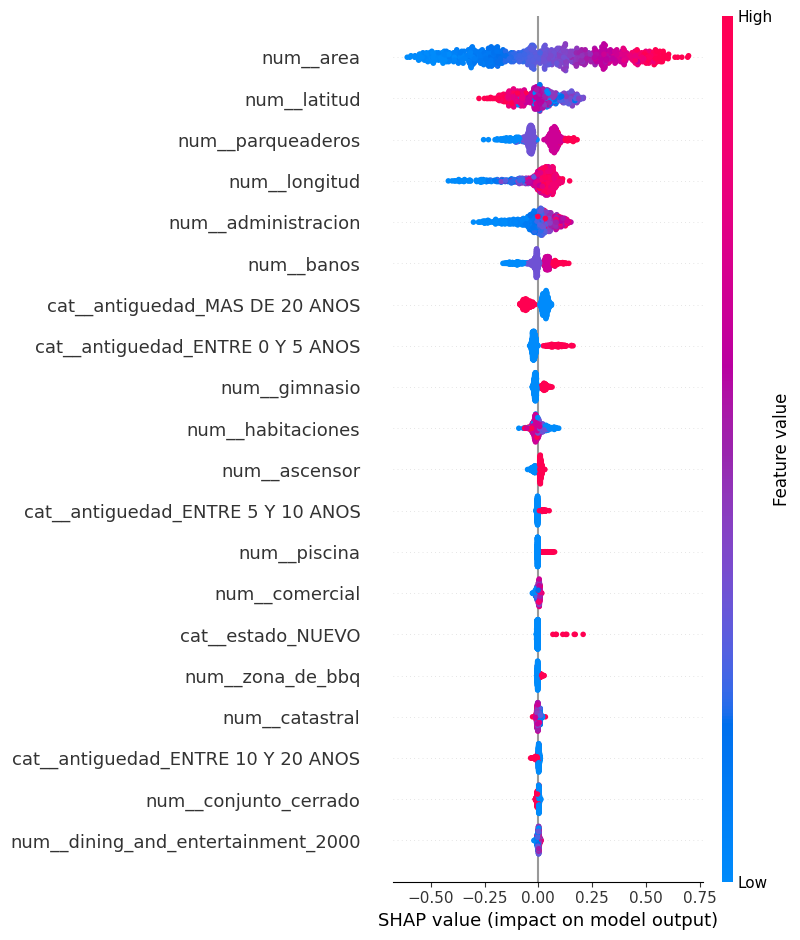

/var/folders/hk/rtpqbyfx3tj0mr3h9pj78nxw0000gn/T/ipykernel_68677/636815388.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sample, plot_type="bar")


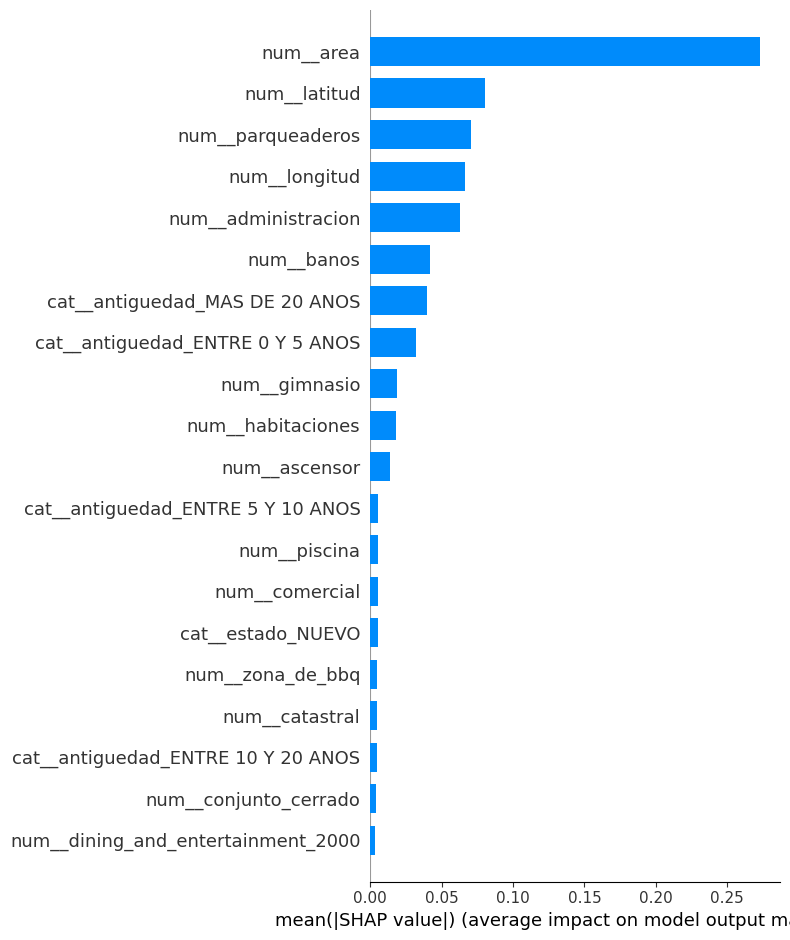

In [ ]:

shap.summary_plot(shap_values.values, X_sample, feature_names=feature_names)
shap.summary_plot(shap_values, X_sample, plot_type="bar")

plt.title('RMSE medio por algoritmo (Modelo Base)')
plt.xticks(rotation=90)

In [12]:
print(shap_importance.head(15))

                              feature  mean_abs_shap
0                           num__area       0.273284
1                        num__latitud       0.080712
2                   num__parqueaderos       0.070309
3                       num__longitud       0.066380
4                 num__administracion       0.062694
5                          num__banos       0.041845
6      cat__antiguedad_MAS DE 20 ANOS       0.039621
7    cat__antiguedad_ENTRE 0 Y 5 ANOS       0.032353
8                       num__gimnasio       0.018622
9                   num__habitaciones       0.018013
10                      num__ascensor       0.013638
11  cat__antiguedad_ENTRE 5 Y 10 ANOS       0.005733
12                       num__piscina       0.005718
13                     num__comercial       0.005381
14                  cat__estado_NUEVO       0.005194


## Modelo enriquecido optimizado (SHAP Values)

In [13]:
vars_optimizadas = [
    "area",
    "latitud",
    "parqueaderos",
    "banos",
    "longitud",
    "administracion",
    "antiguedad",
    "gimnasio",
    "habitaciones",
    "ascensor",
    "piscina",
]

X_opt = X[vars_optimizadas]


num_features = [
    "area", "latitud", "parqueaderos", "banos", "longitud",
    "administracion", "gimnasio", "habitaciones",
    "ascensor", "piscina"
]

cat_features = [
    "antiguedad"
]

preprocessor_opt = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ]
)

In [14]:
from scipy.stats import randint, uniform

xgb_param_dist_opt = {
    # COMPLEJIDAD GENERAL
    "model__n_estimators": randint(200, 400),      # antes hasta 800
    "model__max_depth": randint(3, 6),             # antes hasta 10

    # TASA DE APRENDIZAJE
    "model__learning_rate": uniform(0.02, 0.04),   # [0.02, 0.06]

    # MIN_CHILD_WEIGHT Y GAMMA EVITAN SPLITS DÉBILES
    "model__min_child_weight": randint(3, 10),     # fuerza nodos más grandes
    "model__gamma": uniform(1.0, 2.0),             # exige mejor ganancia en split

    # REGULARIZACIÓN L1 Y L2 (CRÍTICO)
    "model__reg_lambda": uniform(1.0, 3.0),        # L2 fuerte
    "model__reg_alpha": uniform(0.1, 0.8),         # L1 fuerte

    # SUBSAMPLE Y COLSAMPLE
    "model__subsample": uniform(0.6, 0.3),         # [0.6, 0.9]
    "model__colsample_bytree": uniform(0.6, 0.3),  # [0.6, 0.9]
}



pipeline = Pipeline(steps=[("preprocessor", preprocessor_opt), ("model", XGBRegressor(random_state=42))])


search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=xgb_param_dist_opt,
    n_iter=25,
    scoring="neg_root_mean_squared_error",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

inicio = time.time()
search.fit(X_opt, y)
duracion = time.time() - inicio

print(f"Mejor RMSE: {-search.best_score_:.4f}")
print(f"Mejores parámetros: {search.best_params_}")
print(f"Duración: {duracion/60:.1f} minutos")

best_results = {
    "best_rmse": -search.best_score_,
    "best_params": search.best_params_,
    "search_time_min": round(duracion / 60, 2)
}

print(best_results)

best_params = search.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END model__colsample_bytree=0.7123620356542087, model__gamma=2.9014286128198323, model__learning_rate=0.04927975767245621, model__max_depth=3, model__min_child_weight=7, model__n_estimators=302, model__reg_alpha=0.4566662022828729, model__reg_lambda=1.2999247474540088, model__subsample=0.7377746675897601; total time=   0.2s
[CV] END model__colsample_bytree=0.7123620356542087, model__gamma=2.9014286128198323, model__learning_rate=0.04927975767245621, model__max_depth=3, model__min_child_weight=7, model__n_estimators=302, model__reg_alpha=0.4566662022828729, model__reg_lambda=1.2999247474540088, model__subsample=0.7377746675897601; total time=   0.2s
[CV] END model__colsample_bytree=0.7123620356542087, model__gamma=2.9014286128198323, model__learning_rate=0.04927975767245621, model__max_depth=3, model__min_child_weight=7, model__n_estimators=302, model__reg_alpha=0.4566662022828729, model__reg_lambda=1.2999247474540088, m

In [29]:
from xgboost import XGBRegressor

model_opt = XGBRegressor(**best_params)
pipeline_opt = Pipeline(steps=[
    ("preprocessor", preprocessor_opt),
    ("model", model_opt)
])
pipeline_opt.fit(X_opt, y)


from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, root_mean_squared_error, mean_absolute_error, r2_score

scoring = {
    "RMSE": make_scorer(root_mean_squared_error, greater_is_better=False),
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "R2": make_scorer(r2_score)
}

cv_result_opt = cross_validate(
    pipeline_opt,
    X_opt,
    y,
    cv=10,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
    verbose=False
)
save_cv_results_to_csv(cv_result_opt, "resultados/enriquecido_optimizado.csv")


/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [14:24:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "model__colsample_bytree", "model__gamma", "model__learning_rate", "model__max_depth", "model__min_child_weight", "model__n_estimators", "model__reg_alpha", "model__reg_lambda", "model__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [14:24:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "model__colsample_bytree", "model__gamma", "model__learning_rate", "model__max_depth", "model__min_child_weight", "model__n_estimators", "model__reg_alpha", "model__reg_lambda", "model__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/roman/Workspace/maestria/

Archivo guardado en: resultados/enriquecido_optimizado.csv


In [23]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel

# 1. Extraer métricas test (corrigiendo signo)
rmse_test = -cv_result_opt["test_RMSE"]
mae_test  = -cv_result_opt["test_MAE"]
r2_test   =  cv_result_opt["test_R2"]

# 2. Extraer métricas train (corrigiendo signo)
rmse_train = -cv_result_opt["train_RMSE"]
mae_train  = -cv_result_opt["train_MAE"]
r2_train   =  cv_result_opt["train_R2"]

print("======= Resultados Modelo Enriquecido Optimizado (10-Fold CV) =======\n")

# 3. Mostrar estadísticas de RMSE test
print("RMSE Test:")
print(f"  count: {len(rmse_test)}")
print(f"  mean:  {rmse_test.mean():.4f}")
print(f"  std:   {rmse_test.std():.4f}")
print(f"  min:   {rmse_test.min():.4f}")
print(f"  25%:   {np.percentile(rmse_test, 25):.4f}")
print(f"  50%:   {np.percentile(rmse_test, 50):.4f}")
print(f"  75%:   {np.percentile(rmse_test, 75):.4f}")
print(f"  max:   {rmse_test.max():.4f}")

print("\nRMSE Test values:")
print(rmse_test)

# 4. Mostrar estadísticas de MAE y R²
print("\nMAE Test:")
print(f"  mean:  {mae_test.mean():.4f}")
print(f"  std:   {mae_test.std():.4f}")

print("\nR2 Test:")
print(f"  mean:  {r2_test.mean():.4f}")
print(f"  std:   {r2_test.std():.4f}")

# 5. DataFrame completo para sobreajuste
df_opt = pd.DataFrame({
    "RMSE_train": rmse_train,
    "RMSE_test": rmse_test,
    "MAE_train": mae_train,
    "MAE_test": mae_test,
    "R2_train": r2_train,
    "R2_test": r2_test
})

print("\n======= Verificación de Sobreajuste =======\n")
print(df_opt.round(5))
print(df_opt.describe())

# 6. Gap
df_opt["RMSE_gap"] = df_opt["RMSE_test"] - df_opt["RMSE_train"]
df_opt["MAE_gap"]  = df_opt["MAE_test"]  - df_opt["MAE_train"]

print("\nGap promedio (test - train):")
print(df_opt[["RMSE_gap", "MAE_gap"]].mean().round(5))

# 7. Prueba t pareada
t_stat, p_value = ttest_rel(df_opt["RMSE_train"], df_opt["RMSE_test"])

print("\nPrueba t pareada RMSE_train vs RMSE_test:")
print("t =", round(t_stat, 5))
print("p =", p_value)

if p_value < 0.05:
    print("Conclusión: diferencia significativa entre train y test (hay sobreajuste detectable).")
else:
    print("Conclusión: no se detecta diferencia significativa (no hay sobreajuste).")



======= Resultados Modelo Enriquecido Optimizado (10-Fold CV) =======

RMSE Test:
  count: 10
  mean:  0.1480
  std:   0.0055
  min:   0.1401
  25%:   0.1441
  50%:   0.1470
  75%:   0.1503
  max:   0.1602

RMSE Test values:
[0.14326921 0.14334224 0.15340825 0.16024504 0.14784736 0.1480575
 0.14618536 0.15099408 0.14621544 0.14014041]

MAE Test:
  mean:  0.1096
  std:   0.0031

R2 Test:
  mean:  0.9400
  std:   0.0095

======= Verificación de Sobreajuste =======

   RMSE_train  RMSE_test  MAE_train  MAE_test  R2_train  R2_test
0     0.10886    0.14327    0.08259   0.10500   0.96759  0.95854
1     0.10948    0.14334    0.08277   0.10856   0.96875  0.94242
2     0.10837    0.15341    0.08185   0.11445   0.96956  0.92915
3     0.10601    0.16025    0.07991   0.11359   0.97065  0.92845
4     0.10923    0.14785    0.08242   0.11055   0.96888  0.94015
5     0.10766    0.14806    0.08109   0.11244   0.97026  0.92787
6     0.10971    0.14619    0.08259   0.11013   0.96808  0.94572
7     0.1081

In [17]:
# ======================================================
# 3) VALIDACIÓN CRUZADA EN PESOS (correcta con log1p)
# ======================================================

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

rmse_pesos_folds = []
mae_pesos_folds  = []

# CV manual para convertir predicciones log → pesos
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Ajustar modelo
    pipeline_opt.fit(X_train, y_train)

    # Predicción en log
    y_pred_log = pipeline_opt.predict(X_test)

    # Convertir a pesos (valor real)
    y_pred = np.expm1(y_pred_log)
    y_real = np.expm1(y_test)

    # Cálculo en pesos
    rmse_pesos_folds.append(rmse(y_real, y_pred))
    mae_pesos_folds.append(np.mean(np.abs(y_real - y_pred)))

# Tabla resultados en pesos
results_pesos = pd.DataFrame({
    "fold": range(1, kf.get_n_splits() + 1),
    "RMSE_pesos": rmse_pesos_folds,
    "MAE_pesos": mae_pesos_folds
})

print("\n===== VALIDACIÓN CRUZADA EN PESOS (10 folds) =====")
print(results_pesos.describe().round(2))

print("\nRMSE en pesos por fold:")
print(results_pesos["RMSE_pesos"].round(2).values)

print("\nMAE en pesos por fold:")
print(results_pesos["MAE_pesos"].round(2).values)

/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [11:43:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "model__colsample_bytree", "model__gamma", "model__learning_rate", "model__max_depth", "model__min_child_weight", "model__n_estimators", "model__reg_alpha", "model__reg_lambda", "model__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/roman/Workspace/maestria/maestria-ia/analisis/notebooks/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [11:43:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "model__colsample_bytree", "model__gamma", "model__learning_rate", "model__max_depth", "model__min_child_weight", "model__n_estimators", "model__reg_alpha", "model__reg_lambda", "model__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/roman/Workspace/maestria/


===== VALIDACIÓN CRUZADA EN PESOS (10 folds) =====
        fold    RMSE_pesos    MAE_pesos
count  10.00  1.000000e+01        10.00
mean    5.50  1.072336e+08  70992593.23
std     3.03  3.365446e+06   2107691.73
min     1.00  1.009813e+08  66846397.60
25%     3.25  1.054608e+08  70222673.32
50%     5.50  1.075293e+08  71471100.04
75%     7.75  1.100450e+08  72551432.16
max    10.00  1.112820e+08  73289578.08

RMSE en pesos por fold:
[1.05402466e+08 1.10945871e+08 1.07651177e+08 1.10366034e+08
 1.09082037e+08 1.11282038e+08 1.05635899e+08 1.00981314e+08
 1.03581888e+08 1.07407390e+08]

MAE en pesos por fold:
[71104370.98 72736985.54 69982508.96 73289578.08 72982775.77 71994772.01
 70943166.39 66846397.6  68207547.83 71837829.1 ]


## Análisis del error

El análisis de error sirve para entender en qué contextos el modelo acierta o falla más, no solo si tiene buen RMSE general. Es clave en la tesis porque demuestra la validez y robustez del modelo frente a distintos segmentos del mercado.

En concreto:

Por rangos de precio:
Permite ver si el modelo subestima los inmuebles caros (error sistemático típico en datos sesgados) o si mantiene un error constante en todo el rango.

Por estrato socioeconómico:
Indica si el modelo es más preciso en zonas de cierto nivel (por ejemplo, si predice mejor estratos medios que altos o bajos).
Esto aporta evidencia de equidad y estabilidad del modelo.

Por localidad o zona:
Muestra si hay sesgos espaciales (por ejemplo, sobreestimación en el norte o subestimación en el sur de Bogotá).
Es útil para vincular los resultados con la distribución geográfica de los datos enriquecidos.

/var/folders/hk/rtpqbyfx3tj0mr3h9pj78nxw0000gn/T/ipykernel_68677/1382543733.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_precio = df_eval.groupby("rango_precio")[["error_abs", "error_rel"]].mean().reset_index()


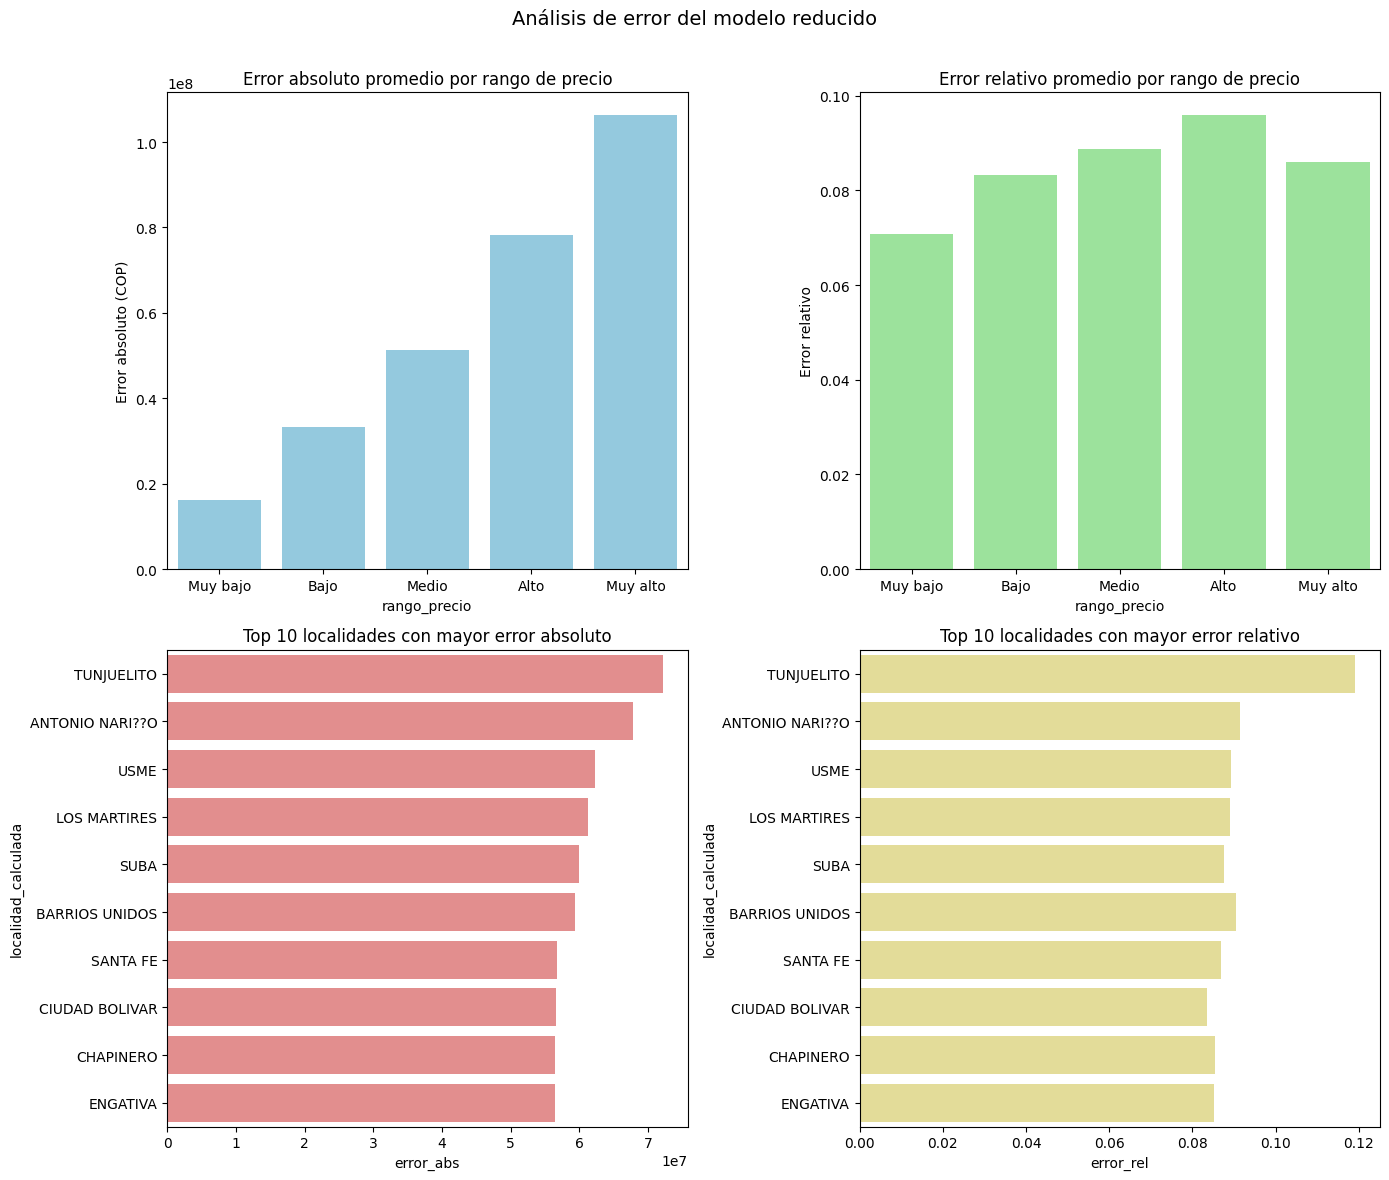

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1) Predicciones en escala original
y_pred_log = pipeline_opt.predict(X)
y_pred = np.expm1(y_pred_log)
y_real = np.expm1(y)

df_eval = df.copy()
df_eval["precio_pred"] = y_pred
df_eval["error_abs"] = abs(df_eval["precio_pred"] - y_real)
df_eval["error_rel"] = abs(df_eval["precio_pred"] - y_real) / y_real

# 2) Análisis por rangos de precio
df_eval["rango_precio"] = pd.qcut(y_real, q=5, labels=["Muy bajo", "Bajo", "Medio", "Alto", "Muy alto"])

error_precio = df_eval.groupby("rango_precio")[["error_abs", "error_rel"]].mean().reset_index()

# 3) Análisis por estrato (si existe)
error_estrato = None
if "estrato" in df_eval.columns:
    error_estrato = df_eval.groupby("estrato")[["error_abs", "error_rel"]].mean().reset_index()

# 4) Análisis por localidad (si existe)
error_localidad = None
if "localidad_calculada" in df_eval.columns:
    error_localidad = df_eval.groupby("localidad_calculada")[["error_abs", "error_rel"]].mean().reset_index()

# 5) Gráficos
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
plt.suptitle("Análisis de error del modelo reducido", fontsize=14)

# Error por rango de precio
sns.barplot(data=error_precio, x="rango_precio", y="error_abs", ax=axes[0,0], color="skyblue")
axes[0,0].set_title("Error absoluto promedio por rango de precio")
axes[0,0].set_ylabel("Error absoluto (COP)")

sns.barplot(data=error_precio, x="rango_precio", y="error_rel", ax=axes[0,1], color="lightgreen")
axes[0,1].set_title("Error relativo promedio por rango de precio")
axes[0,1].set_ylabel("Error relativo")

# Error por estrato
if error_estrato is not None:
    sns.barplot(data=error_estrato, x="estrato", y="error_abs", ax=axes[1,0], color="salmon")
    axes[1,0].set_title("Error absoluto promedio por estrato")
    sns.barplot(data=error_estrato, x="estrato", y="error_rel", ax=axes[1,1], color="orange")
    axes[1,1].set_title("Error relativo promedio por estrato")

# Error por localidad
if error_localidad is not None:
    top_localidades = error_localidad.sort_values("error_abs", ascending=False).head(10)
    sns.barplot(data=top_localidades, y="localidad_calculada", x="error_abs", ax=axes[1,0], color="lightcoral")
    axes[1,0].set_title("Top 10 localidades con mayor error absoluto")
    sns.barplot(data=top_localidades, y="localidad_calculada", x="error_rel", ax=axes[1,1], color="khaki")
    axes[1,1].set_title("Top 10 localidades con mayor error relativo")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


## Exportación de resultados

Se exportan los resultados para poder compararlo luego

In [ ]:
import cloudpickle
import os
from pathlib import Path

def export_model(model, file_name: Path):
    # guardar el pipeline
    os.makedirs("../data/models", exist_ok=True)
    file_path = Path("../data/models") / f"{file_name}.pkl"
    with open(file_path, "wb") as f:
        cloudpickle.dump({
            "model": model
        }, f)
    print(f"Pipeline exportado a '{file_path}'")

In [22]:
export_model(pipeline_opt, "modelo_aumentado_reducido")

Pipeline exportado a '../data/models/modelo_aumentado_reducido.pkl'
